In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob 

import sns
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages

from scipy.sparse import coo_matrix

import cooler

mpl.rcParams['pdf.fonttype'] = 42

sns.set_context('paper', 
   rc={'font.size':14, 'axes.titlesize':14,'axes.labelsize':14,'xtick.labelsize':14, 'ytick.labelsize':14})

In [2]:
fruitpunch = LinearSegmentedColormap.from_list("bright_red", [(1,1,1),(1,0,0)])

def virtual_4C(clr, viewpoint, region):
       
    import re
    
    vp_chrom, vp_start, vp_end = re.split('[:-]', viewpoint)
    
    total_contacts = np.nansum(clr.matrix(balance='KR').fetch(viewpoint, vp_chrom))
    
    matrix = clr.matrix(balance='KR').fetch(region)
    
    N, _ = matrix.shape
    x, y = range(N-1), range(1, N)
    matrix[x, y] = np.nan
    matrix[y, x] = np.nan
    np.fill_diagonal(matrix, np.nan)

    bins = clr.bins().fetch(region)
    positions = list(bins.index)
    vp_position = list(bins[(bins.chrom==vp_chrom) & (bins.start==int(vp_start))].index)[0]
    rel_position = np.asarray(positions) - vp_position
    
    virtual_4c_profile = matrix[vp_position - positions[0], :]/total_contacts
    
    return rel_position, virtual_4c_profile

**Example genes (hg38)**

1. NFKB1: chr4:102,501,331-102,617,302
2. IKZF2: chr2:212,999,691-213,152,456
3. MYC: chr8:127,735,434-127,742,951

Note that FPKM values were taken from LiMCA gene expression tables!

In [3]:
clrs_gen = {
    'IKZF2_high':  cooler.Cooler('genes/IKZF2_expression_high/IKZF2_expression_high.mcool::/resolutions/10000'),
    'IKZF2_low' :  cooler.Cooler('genes/IKZF2_expression_low/IKZF2_expression_low.mcool::/resolutions/10000'),
    'NFKB1_high':  cooler.Cooler('genes/NFKB1_expression_high/NFKB1_expression_high.mcool::/resolutions/10000'),
    'NFKB1_low' :  cooler.Cooler('genes/NFKB1_expression_low/NFKB1_expression_low.mcool::/resolutions/10000'),
    'MYC_high'  :  cooler.Cooler('genes/MYC_expression_high/MYC_expression_high.mcool::/resolutions/10000'),
    'MYC_low'   :  cooler.Cooler('genes/MYC_expression_low/MYC_expression_low.mcool::/resolutions/10000')
}

nfkb1_mats = {
    'high': clrs_gen['NFKB1_high'].matrix(balance='KR').fetch('4:102,100,000-102,900,000'),
    'low' : clrs_gen['NFKB1_low'].matrix(balance='KR').fetch('4:102,100,000-102,900,000'),
}

ikzf2_mats = {
    'high' : clrs_gen['IKZF2_high'].matrix(balance='KR').fetch('2:212,700,000-213,500,000'),
    'low'  : clrs_gen['IKZF2_low'].matrix(balance='KR').fetch('2:212,700,000-213,500,000'),
}

myc_mats = {
    'high' : clrs_gen['MYC_high'].matrix(balance='KR').fetch('8:127,000,000-128,500,000'),
    'low'  : clrs_gen['MYC_low'].matrix(balance='KR').fetch('8:127,000,000-128,500,000')
}

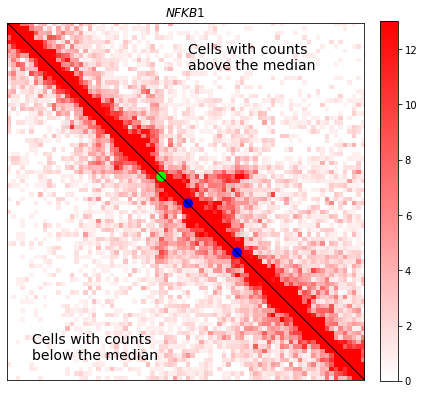

In [7]:
f, ax = plt.subplots(figsize=(6, 6))
mat1 = np.tril(nfkb1_mats['low']) + np.triu(nfkb1_mats['high'])
# np.fill_diagonal(mat1, np.nan)
im = ax.matshow(mat1, vmax=13, vmin=0, cmap=fruitpunch)
draw_circle = patches.Circle((34, 34), 1, color='lime')
ax.add_artist(draw_circle)
draw_circle = patches.Circle((40, 40), 1, color='blue')
ax.add_artist(draw_circle)
draw_circle = patches.Circle((51, 51), 1, color='blue')
ax.add_artist(draw_circle)
_ = ax.plot([-0.5, 79.5], [-0.5, 79.5], color='k', lw=1)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

_ = ax.set(xticks=list(), yticks=list(),title='$\it{NFKB1}$')
_ = ax.text(40,10, 'Cells with counts\nabove the median', fontsize=14)
_ = ax.text(5,75, 'Cells with counts\nbelow the median', fontsize=14)
plt.tight_layout()

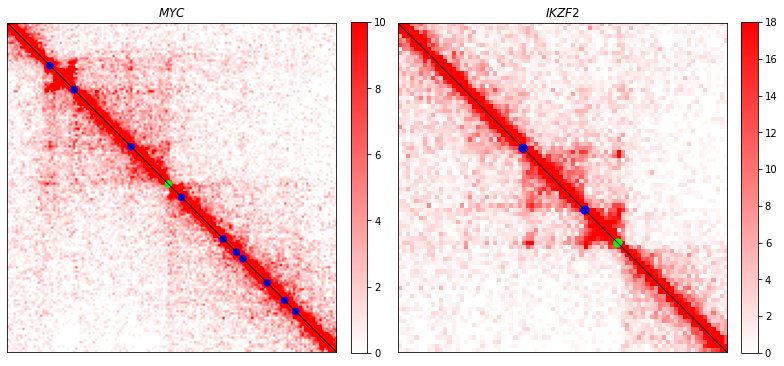

In [8]:
f, axs = plt.subplots(figsize=(11, 5), nrows=1, ncols=2)

ax = axs[0]
mat = np.tril(myc_mats['low']) + np.triu(myc_mats['high'])
mat_N, _ = mat.shape
im = ax.imshow(mat, vmin=0, vmax=10, cmap=fruitpunch)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
_ = ax.set(xticks=list(), yticks=list(),title='$\it{MYC}$')
_ = ax.plot([-0.5, mat_N - 0.5], [-0.5, mat_N - 0.5], color='k', lw=1)

circles = [19, 30, 56, 79, 98,104, 107,118, 126, 131]
for i in circles:
    draw_circle1 = patches.Circle((i, i), 1.5, color='blue')
    ax.add_artist(draw_circle1)
draw_circle1 = patches.Circle((73, 73), 1.5, color='lime')
_ = ax.add_artist(draw_circle1)

ax = axs[1] # IKZF2 Genes
mat2 = np.tril(ikzf2_mats['low']) + np.triu(ikzf2_mats['high'])
im = ax.matshow(mat2, vmax=18, vmin=0, cmap=fruitpunch)
draw_circle1 = patches.Circle((53, 53), 1, color='lime')
ax.add_artist(draw_circle1)
draw_circle1 = patches.Circle((30, 30), 1, color='blue')
ax.add_artist(draw_circle1)
draw_circle1 = patches.Circle((45, 45), 1, color='blue')
ax.add_artist(draw_circle1)
_ = ax.plot([-0.5, 79.5], [-0.5, 79.5], color='k', lw=1)
_ = ax.set(xticks=list(), yticks=list(),title='$\it{IKZF2}$')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()

In [9]:
rel_pos1, virtual_profiles1 = virtual_4C(clrs_gen['NFKB1_high'], '4:102440000-102450000', '4:102300000-102750000')
rel_pos2, virtual_profiles2 = virtual_4C(clrs_gen['NFKB1_low'], '4:102440000-102450000', '4:102300000-102750000')

rel_pos3, virtual_profiles3 = virtual_4C(clrs_gen['IKZF2_high'], '2:213230000-213240000', '2:212950000-213340000')
rel_pos4, virtual_profiles4 = virtual_4C(clrs_gen['IKZF2_low'], '2:213230000-213240000',  '2:212950000-213340000')

rel_pos5, virtual_profiles5 = virtual_4C(clrs_gen['MYC_high'], '8:127730000-127740000', '8:127,000,000-128,500,000'.replace(',', ''))
rel_pos6, virtual_profiles6 = virtual_4C(clrs_gen['MYC_low'], '8:127730000-127740000',  '8:127,000,000-128,500,000'.replace(',', ''))

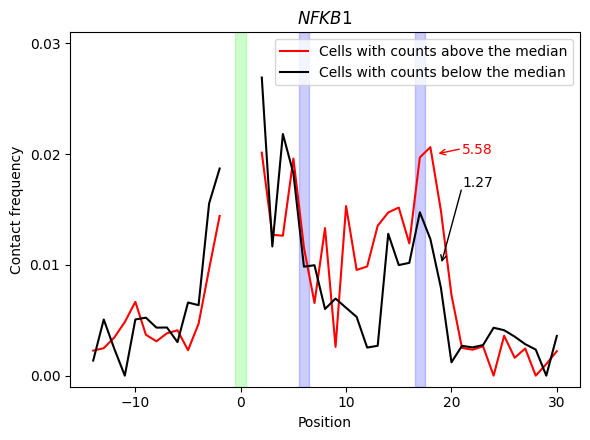

In [10]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4.5), dpi=100)

ax.plot(rel_pos1, virtual_profiles1, color='r', lw=1.5, label='Cells with counts above the median')
ax.plot(rel_pos2, virtual_profiles2, color='k', lw=1.5, label='Cells with counts below the median')
ax.fill_between([-0.5,0.5], -0.001, 0.031,  alpha=0.2, color='lime')
ax.fill_between([5.5,6.5], -0.001, 0.031,  alpha=0.2, color='blue')
ax.fill_between([16.5,17.5], -0.001, 0.031,  alpha=0.2, color='blue')
_ = ax.set(ylim=(-0.001, 0.031), yticks=[0, 0.01, 0.02, 0.03],title='$\it{NFKB1}$', xlabel='Position', ylabel='Contact frequency')
ax.legend(fontsize=10)
_ = ax.text(21, 0.02, '5.58', color='r')
_ = ax.text(21, 0.017, '1.27', color='k')
ax.annotate('', xy=(18.5, 0.02), xytext=(21, 0.0205), arrowprops={'arrowstyle':'->', 'color':'r'})
ax.annotate('', xy=(19, 0.01), xytext=(21, 0.017), arrowprops={'arrowstyle':'->', 'color':'k'})
plt.tight_layout()

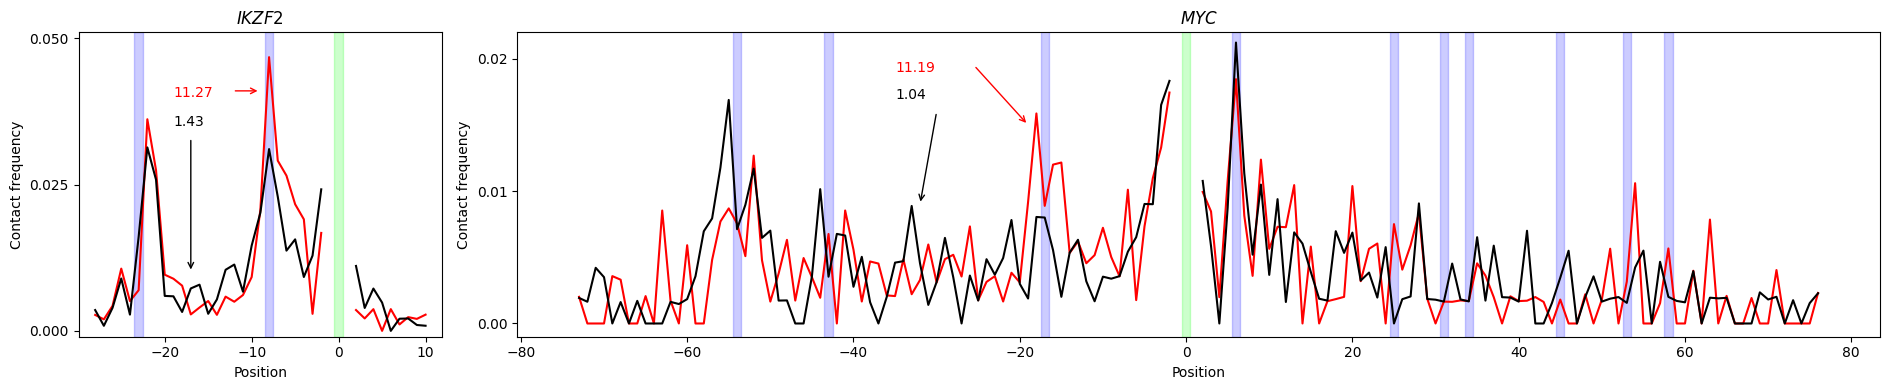

In [12]:
f, axs = plt.subplots(figsize=(19,4), dpi=100, nrows=1, ncols=2, gridspec_kw={'width_ratios': [1, 3.75]} )

ax = axs[0]
ax.plot(rel_pos3, virtual_profiles3, color='r', label='Cells with counts above the median')
ax.plot(rel_pos4, virtual_profiles4, color='k', label='Cells with counts below the median')
ax.fill_between([-0.5,0.5], -0.001, 0.051,  alpha=0.2, color='lime')
ax.fill_between([-8.5,-7.5], -0.001, 0.051,  alpha=0.2, color='blue')
ax.fill_between([-23.5,-22.5], -0.001, 0.051,  alpha=0.2, color='blue')
_ = ax.set(ylim=(-0.001, 0.051), title='$\it{IKZF2}$', xlabel='Position', ylabel='Contact frequency', yticks=[0, 0.025, 0.05])
_ = ax.text(-19, 0.04, '11.27', color='r')
_ = ax.text(-19, 0.035, '1.43', color='k')
ax.annotate('', xy=(-9, 0.041), xytext=(-12.2, 0.041), arrowprops={'arrowstyle':'->', 'color':'r'})
ax.annotate('', xy=(-17, 0.01), xytext=(-17, 0.033), arrowprops={'arrowstyle':'->', 'color':'k'})


ax = axs[1]
ax.plot(rel_pos5, virtual_profiles5, color='r', lw=1.5, label='Cells with counts above the median')
ax.plot(rel_pos6, virtual_profiles6, color='k', lw=1.5, label='Cells with counts below the median')

_ = ax.fill_between([-54.5,-53.5], -0.001, 0.031,  alpha=0.2, color='blue') # 127,190,000
_ = ax.fill_between([-43.5,-42.5], -0.001, 0.031,  alpha=0.2, color='blue') # 127,300,000
_ = ax.fill_between([-17.5,-16.5], -0.001, 0.031,  alpha=0.2, color='blue') # 127,560,000
_  = ax.fill_between([-0.5,0.5], -0.001, 0.051,  alpha=0.2, color='lime') # viewpoint

### downstream
_ = ax.fill_between([5.5,6.5], -0.001, 0.022,  alpha=0.2, color='blue') # 127,790,000
# _ = ax.fill_between([15.5,16.5], -0.001, 0.031,  alpha=0.2, color='blue')  # 127,880,000, ATAC-peak, not an enhancer
_ = ax.fill_between([24.5,25.5], -0.001, 0.022,  alpha=0.2, color='blue')  # 127,980,000
_ = ax.fill_between([30.5,31.5], -0.001, 0.022,  alpha=0.2, color='blue')  # 128,040,000
_ = ax.fill_between([33.5,34.5], -0.001, 0.022,  alpha=0.2, color='blue')  # 128,070,000
_ = ax.fill_between([44.5,45.5], -0.001, 0.022,  alpha=0.2, color='blue')  # 128,180,000, weak enhancer
_ = ax.fill_between([52.5,53.5], -0.001, 0.022,  alpha=0.2, color='blue')  # 128,260,000

_ = ax.fill_between([57.5, 58.5], -0.001, 0.022,  alpha=0.2, color='blue') # 128,310,000
_ = ax.set(ylim=(-0.001, 0.022),  title='$\it{MYC}$', xlabel='Position', ylabel='Contact frequency', yticks=[0, 0.01, 0.02])
_ = ax.text(-35, 0.019, '11.19', color='r')
_ = ax.text(-35, 0.017, '1.04', color='k')
ax.annotate('', xy=(-19, 0.015), xytext=(-25.5, 0.0195), arrowprops={'arrowstyle':'->', 'color':'r'})
ax.annotate('', xy=(-32, 0.009), xytext=(-30, 0.016), arrowprops={'arrowstyle':'->', 'color':'k'})
plt.tight_layout()